In [1]:
#function example with several unknowns (variables) for optimization
#Gerald Schuller, Nov. 2016
import numpy as np

def functionexamp(x):
    #x: array with 2 variables
    
    y=np.sin(x[0])+np.cos(x[1])
    return y

In [2]:
#Optimization example, see also:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html
#Gerald Schuller, Nov. 2016
#run it with "python optimizationExample.py" in a termina shell
#or type "ipython" in a termina shell and copy lines below:

import numpy as np
import scipy.optimize as optimize

#Example for 2 unknowns, args: function-name, starting point, method:
xmin = optimize.minimize(functionexamp, [-1.0, -3.0], method='CG')
print(xmin)

     fun: -1.9999999999888387
     jac: array([4.7236681e-06, 0.0000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 3
  status: 0
 success: True
       x: array([-1.5707916 , -3.14159265])


In [ ]:
function [p,passedge] = opt_filter(filtorder,N)

% opt_filter      Create Lowpass Prototype Filter for the Pseudo-QMF 
%                 Filter Bank with N Subbands
%
% Adapted from the paper by C. D. Creusere and S. K. Mitra, titled 
%   "A simple method for designing high-quality prototype filters for 
%   M-band pseudo-QMF banks," IEEE Trans. Signal Processing,vol. 43, 
%   pp. 1005-1007, Apr. 1995 and the book by S. K. Mitra titled "
%   Digital Signal Processing: A Computer-Based Approach, McGraw-Hill, 2001
%
% Arguments:
% filtorder     Filter order (i.e., filter length - 1)
% N             Number of subbands

stopedge = 1/N;       % Stopband edge fixed at (1/N)pi
passedge = 1/(4*N);   % Start value for passband edge
tol = 0.000001;       % Tolerance
step = 0.1*passedge;  % Step size for searching the passband edge
way = -1;             % Search direction, increase or reduce the passband edge
tcost = 0;            % Current error calculated with the cost function
pcost = 10;           % Previous error calculated with the cost function
flag = 0;             % Set to 1 to stop the search

while flag == 0
    
% Design the lowpass filter using Parks-McClellan algorithm
 
    p = remez(filtorder,[0,passedge,stopedge,1],[1,1,0,0],[5,1]);
    
% Calculates the cost function according to Eq. (2.36)

    P = fft(p,4096);
    OptRange = floor(2048/N);           % 0 to pi/N
    phi = zeros(OptRange,1);            % Initialize to zeros

% Compute the flatness in the range from 0 to pi/N

	for k = 1:OptRange
          phi(k) = abs(P(OptRange-k+2))^2 + abs(P(k))^2;
	end
	tcost = max(abs(phi - ones(max(size(phi)),1)));
   	
	if tcost > pcost                % If search in wrong direction
		step = step/2;          % Reduce step size by half 
		way = -way;             % Change the search direction 
	end
	
	if abs(pcost - tcost) < tol     % If improvement is below tol         
		flag = 1;               % Stop the search                    
	end
	
	pcost = tcost;
	passedge = passedge + way*step; % Adjust the passband edge
   
end

In [ ]:
sig.remez

In [101]:
1 / 4. / 20.0

0.0125

In [90]:
p = sig.remez(65, [0, 1/16.0, 1/4.0, 1], [1, 0], [5, 1])


ValueError: Band edges should be less than 1/2 the sampling frequency

In [ ]:
def create_pqmf_filter(filter_len=64, N=4):
    stop_edge = 1 / N
    pass_edge = 1 / (4 * N)
    tol = 1e-8
    cutoff = 0.1 * pass_edge
    cost = 0
    cost_prev = float('inf')
    
    p = sig.remez(filter_len, [0, pass_edge, stop_edge, 1], [1, 1, 0, 0], [5, 1])
    
    P = sig.freqz(p, workN=2048)
    opt_range = 2048 // N
    phi = np.zeros(opt_range)
    
    H = np.abs(P)
    phi = H[opt_range  + 2] 
    for i in range(opt_range):
        phi[i] = abs(P(opt_range - i + 2)) ** 2 + abs(P[i]) ** 2

In [81]:
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline


def optimfuncQMF(x):
    """Optimization function for a PQMF Filterbank
    x: coefficients to optimize (first half of prototype h because of symmetry)
    err: resulting total error
    """
    K = ntaps * N 
    h = np.append(x, np.flipud(x))
    cutoff = 0.15
    
#     breakpoint()
    f, H_im = sig.freqz(h, worN=K)
    H = np.abs(H_im) #only keeping the real part
    
    posfreq = np.square(H[0:K//N])
    
    #Negative frequencies are symmetric around 0:
    negfreq = np.flipud(np.square(H[0:K//N]))
    
    #Sum of magnitude squared frequency responses should be closed to unity (or N)
    unitycond = np.sum(np.abs(posfreq + negfreq - 2*(N*N)*np.ones(K//N)))/K
    
    #plt.plot(posfreq+negfreq)
    
    #High attenuation after the next subband:
    att = np.sum(np.abs(H[int(cutoff*K//N):]))/K
    
    #Total (weighted) error:
    err = unitycond + 100*att
    return err

In [85]:
xmin.shape

(32,)

8.684549400499243


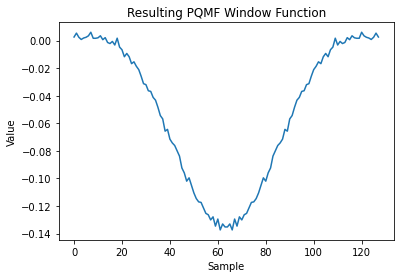

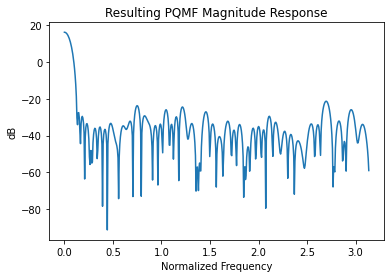

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig

ntaps = 64
N = 4

#optimize for 16 filter coefficients:
xmin = opt.minimize(optimfuncQMF, ntaps*np.ones(ntaps), method='SLSQP', tol=1e-8)
xmin = xmin["x"]

err = optimfuncQMF(xmin)
print(err)

#Restore symmetric upper half of window:
h = np.concatenate((xmin, np.flipud(xmin)))
plt.plot(h)
plt.title('Resulting PQMF Window Function')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

f, H = sig.freqz(h)
plt.plot(f, 20*np.log10(np.abs(H)))
plt.title('Resulting PQMF Magnitude Response')
plt.xlabel('Normalized Frequency')
plt.ylabel('dB')
plt.show()

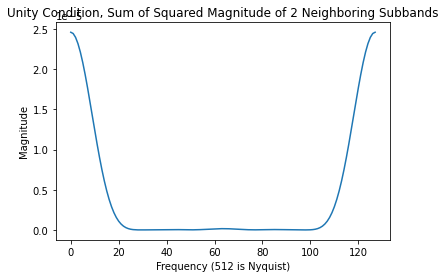

In [56]:
N = 4
f, H_im = sig.freqz(h)
posfreq = np.square(H[0:512//N])
negfreq = np.flipud(np.square(H[0:512//N]))
plt.plot((np.abs(posfreq) + np.abs(negfreq)))
plt.xlabel('Frequency (512 is Nyquist)')
plt.ylabel('Magnitude')
plt.title('Unity Condition, Sum of Squared Magnitude of 2 Neighboring Subbands')
plt.show()

In [57]:
b = sig.firwin(80, 0.5, window=('kaiser', 8))

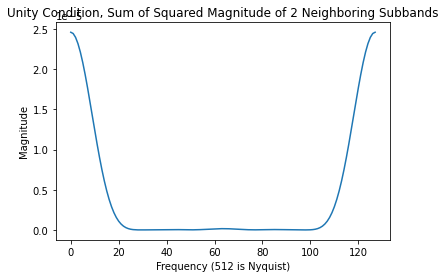

In [58]:
f, H_im = sig.freqz(h)
posfreq = np.square(H[0:512//N])
negfreq = np.flipud(np.square(H[0:512//N]))
plt.plot((np.abs(posfreq) + np.abs(negfreq)))
plt.xlabel('Frequency (512 is Nyquist)')
plt.ylabel('Magnitude')
plt.title('Unity Condition, Sum of Squared Magnitude of 2 Neighboring Subbands')
plt.show()

In [79]:
b.shape

(63,)

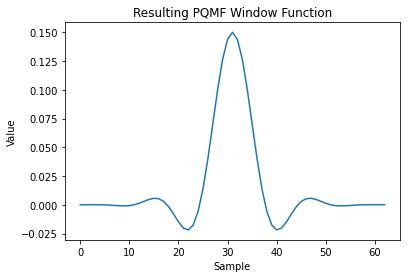

In [102]:
cutoff = 0.15
beta = 9
ntaps = 63
N = 4

b = sig.firwin(ntaps, cutoff, window=('kaiser', beta))
w, h = sig.freqz(b)

plt.plot(b)
plt.title('Resulting PQMF Window Function')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

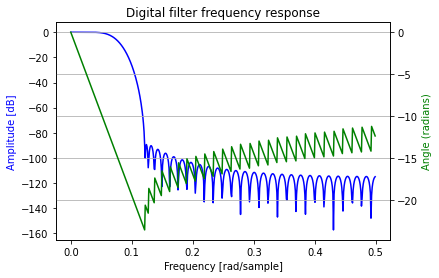

In [103]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w / (2 * np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w / (2 * np.pi), angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

In [105]:
b.shape

(63,)

In [129]:
def optimfuncQMF(x):
    """Optimization function for a PQMF Filterbank
    x: coefficients to optimize (first half of prototype h because of symmetry)
    err: resulting total error
    """
    N = 2 #4 subbands
    cutoff = 1.5 #1.5
    h = np.append(x, np.flipud(x))
    f, H_im = sig.freqz(h)
    H = np.abs(H_im) #only keeping the real part
    
    posfreq = np.square(H[0:512//N])
    
    #Negative frequencies are symmetric around 0:
    negfreq = np.flipud(np.square(H[0:512//N]))
    
    #Sum of magnitude squared frequency responses should be closed to unity (or N)
    unitycond = np.sum(np.abs(posfreq + negfreq - 2*(N*N)*np.ones(512//N)))//512
    
    #plt.plot(posfreq+negfreq)
    
    #High attenuation after the next subband:
    att = np.sum(np.abs(H[int(cutoff*512//N):]))//512
    
    #Total (weighted) error:
    err = unitycond + 100*att
    return err

3.0


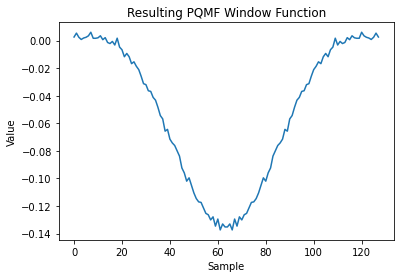

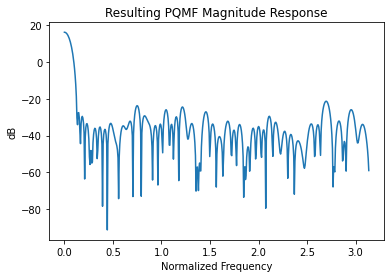

In [131]:
err = optimfuncQMF(b)
print(err)

#Restore symmetric upper half of window:
h = np.concatenate((xmin, np.flipud(xmin)))
plt.plot(h)
plt.title('Resulting PQMF Window Function')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

f, H = sig.freqz(h)
plt.plot(f, 20*np.log10(np.abs(H)))
plt.title('Resulting PQMF Magnitude Response')
plt.xlabel('Normalized Frequency')
plt.ylabel('dB')
plt.show()